# Wstęp

W tym zadaniu zajmiemy się grupowaniem (klasteryzacją), czyli podziałem danych na zbiory na podstawie wartości opisujących ich cech. Sprawdzimy też, dlaczego standaryzacja jest tak ważnym etapem przygotowania danych.

Celem klasteryzacji jest eksploracja danych - sprawdzamy, czy dane da się podzielić na skupienia (zbiory różniące się pomiędzy sobą i możliwe do odróżnienia) na podstawie posiadanych cech. Na tej podstawie możemy podzielić zbiór danych na klasy i utworzyć etykiety, które mogą zostać potem wykorzystane do klasyfikacji.

## Wczytanie i porządkowanie danych
Zacznijmy od wczytania danych, na których będziemy pracować. Zawierają one 8 cech charakteryzujących utwory muzyczne oraz przypisanie do 1 z 16 gatunków.

Źródło danych: https://github.com/mdeff/fma

In [237]:
# !unzip fma_metadata.zip -d fma_metadata # opcja -d służy do podania docelowego katalogu

In [238]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

Wczytamy dane do DataFrame'a; na początek dobrze jest zapoznać się z zawartością pliku .csv, żeby wiedzieć, w jaki sposób to zrobić, i czy potrzebne są jakieś porządki. Najpierw wczytamy plik z cechami utworów:

In [239]:
feats_col_list = np.arange(9) # lista od 0 do 8 - bierzemy tylko kolumny z indeksem utworu oraz jego cechami
feats_df = pd.read_csv("fma_metadata/echonest.csv", usecols=feats_col_list, low_memory=False, header=2) 
#header - numer wiersza, w którym jest nazwa cechy i który będzie nagłówkiem kolumn
#low_memory=False - dzięki temu nie wyświetla się ostrzeżenie, że wczytywane są różne typy danych do jednej tabeli

feats_df.rename(columns={'Unnamed: 0': 'track_id'}, inplace=True) #zmiana nagłówka pierwszej kolumny
#inplace=True oznacza, że modyfikujemy oryginalną tabelę feats_df, a nie tworzymy jej kopię
feats_df.dropna(inplace=True) #usuwamy wiersze, w których jest NaN (czyli pusta komórka w .CSV)
#musimy zrestetować index - po usunięciu wierszy usunięte są też ich indeksy
feats_df.reset_index(drop=True, inplace=True) 
#drop=True oznacza, że nie tworzymy nowej kolumny z zachowanymi starymi indeksami, bo nie jest nam potrzebna

A następnie plik z przypisaniem utworów do gatunków muzycznych.

In [240]:
genre_col_list = [0,40] # bierzemy kolumny z track_id oraz nazwą gatunku
genre_df = pd.read_csv("fma_metadata/tracks.csv", usecols=genre_col_list, low_memory=False, header=1)
genre_df.rename(columns={'Unnamed: 0': 'track_id'}, inplace=True)
genre_df.dropna(inplace=True)
genre_df.reset_index(drop=True, inplace=True)

Zobaczmy, jakie gatunki muzyczne mamy w wykorzystywanym zbiorze danych:

In [241]:
genre_df["genre_top"].unique()

array(['Hip-Hop', 'Pop', 'Rock', 'Experimental', 'Folk', 'Jazz',
       'Electronic', 'Spoken', 'International', 'Soul-RnB', 'Blues',
       'Country', 'Classical', 'Old-Time / Historic', 'Instrumental',
       'Easy Listening'], dtype=object)

## Kodowanie etykiet

Gatunki są określone słownie - takie przypisanie nie nadaje się do zastosowania z większością algorytmów uczenia maszynowego. Musimy przypisać im wartości liczbowe, które posłużą jako etykiety. Skorzystamy z metody [map](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.map.html), która „przetłumaczy” nam etykiety element po elemencie.

In [242]:
#tworzymy słownik, który posłuży do zamiany etykiet słownych na numeryczne
labels_dict = {value: index for index, value in enumerate(genre_df["genre_top"].unique())}

#dodajemy nową kolumnę do tabeli genre_df i wpisujemy do niej etykiety numeryczne poszczególnych utworów
genre_df['genre_numeric_label'] = genre_df["genre_top"].map(labels_dict)

for key in labels_dict:
    print(labels_dict[key], key)

0 Hip-Hop
1 Pop
2 Rock
3 Experimental
4 Folk
5 Jazz
6 Electronic
7 Spoken
8 International
9 Soul-RnB
10 Blues
11 Country
12 Classical
13 Old-Time / Historic
14 Instrumental
15 Easy Listening


Łączymy obie tabele (z cechami oraz gatunkami poszczególnych utworów) w taki sposób, żeby zachować tylko indeksy utworów, które występują w obu tabelach (`how='inner'`). Argument `on` określa, względem której kolumny łączymy tabele (musi ona być obecna w obu).

(Metoda [merge](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html#pandas.DataFrame.merge) bazuje na SQL-owym poleceniu JOIN i ma podobną logikę działania.)

In [243]:
all_data_df = pd.merge(feats_df, genre_df, on='track_id', how='inner')
all_data_df

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top,genre_numeric_label
0,2,0.416675,0.675894,0.634476,1.062807e-02,0.177647,0.159310,165.922,0.576661,Hip-Hop,0
1,3,0.374408,0.528643,0.817461,1.851103e-03,0.105880,0.461818,126.957,0.269240,Hip-Hop,0
2,5,0.043567,0.745566,0.701470,6.967990e-04,0.373143,0.124595,100.260,0.621661,Hip-Hop,0
3,10,0.951670,0.658179,0.924525,9.654270e-01,0.115474,0.032985,111.562,0.963590,Pop,1
4,134,0.452217,0.513238,0.560410,1.944269e-02,0.096567,0.525519,114.290,0.894072,Hip-Hop,0
...,...,...,...,...,...,...,...,...,...,...,...
9350,124718,0.412194,0.686825,0.849309,6.000000e-10,0.867543,0.367315,96.104,0.692414,Hip-Hop,0
9351,124719,0.054973,0.617535,0.728567,7.215700e-06,0.131438,0.243130,96.262,0.399720,Hip-Hop,0
9352,124720,0.010478,0.652483,0.657498,7.098000e-07,0.701523,0.229174,94.885,0.432240,Hip-Hop,0
9353,124721,0.067906,0.432421,0.764508,1.625500e-06,0.104412,0.310553,171.329,0.580087,Hip-Hop,0


Sprawdźmy, ile gatunków mamy do dyspozycji po złączeniu tabel (na początku usunęliśmy rekordy z brakującymi danymi z tabeli z parametrami). Wyświetlimy od razu liczbę utworów każdego gatunku:

In [244]:
all_data_df["genre_top"].value_counts()

genre_top
Rock                   3892
Electronic             2170
Hip-Hop                 910
Folk                    874
Old-Time / Historic     357
Pop                     346
Classical               265
Jazz                    241
International           133
Instrumental             84
Blues                    66
Experimental             17
Name: count, dtype: int64

Żeby było nam łatwiej analizować działanie algorytmu, wybierzemy tylko najliczniejsze gatunki (zawierające przynajmniej 200 przykładów):

In [245]:
counter_s = all_data_df["genre_top"].value_counts()
selected_genres = counter_s[counter_s >= 200].index
all_data_df = all_data_df[all_data_df.genre_top.isin(selected_genres)]
all_data_df.reset_index(drop=True, inplace=True)
all_data_df["genre_top"].value_counts()

genre_top
Rock                   3892
Electronic             2170
Hip-Hop                 910
Folk                    874
Old-Time / Historic     357
Pop                     346
Classical               265
Jazz                    241
Name: count, dtype: int64

Skoro mamy już przygotowane dane, zapiszemy tę tabelę do pliku, przyda się w następnym zadaniu.

In [246]:
all_data_df.to_csv("all_data.csv", index=False)
# index=False - nie zapisujemy kolumny z indeksami, track_id jest anszym identyfikatorem

# PCA

Po uporządkowaniu danych mamy 8 gatunków w zbiorze. Każdy utwór opisywany jest przez 8 cech. Jest to zbyt dużo, żeby dało się je łatwo zwizualizować na płaszczyźnie i zobaczyć, czy tworzą się skupienia zawierające utwory z poszczególnych gatunków. Zastosujemy PCA, żeby sprawdzić czy możemy zredukować liczbę wymiarów, i zwizualizujemy dane na płaszczyźnie PC1-PC2.

In [247]:
feats_names = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness", "tempo", "valence"] # wektor zawierający nazwy cech, które będą podane do PCA. Na razie bierzemy wszystkie 8
# zapiszemy je od razu do pliku
np.savetxt('features_list.txt', feats_names, fmt='%s')

Nie będziemy przeprowadzać klasyfikacji, więc do PCA możemy podać wszystkie dane, bez podziału na zbiór uczący i testowy.

In [248]:
pca = PCA(n_components=8)

PCA_feats = pca.fit_transform(all_data_df[feats_names])

Sprawdźmy, jaka część wariancji jest wyjaśniana przez kolejne składowe główne:

In [249]:
# ustawiamy parametry wyświetlania liczb, suppress=True wyłącza notację wykładniczą
with np.printoptions(precision=4, suppress=True):
    print(pca.explained_variance_ratio_)

[0.9996 0.0001 0.0001 0.0001 0.     0.     0.     0.    ]


Jak widać, prawie cała wariancja jest wyjaśniana przez zaledwie 1 składową główną. Zajmiemy się tym za chwilę - na razie do tabeli z danymi dodamy PC1 i PC2.

In [250]:
all_data_df.loc[:, 'PC1'] = PCA_feats[:, 0]
all_data_df.loc[:, 'PC2'] = PCA_feats[:, 1]

/var/folders/bk/2_0z1p453hx_s4fbqb5k60mm0000gn/T/ipykernel_51463/1685291749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_df.loc[:, 'PC1'] = PCA_feats[:, 0]
/var/folders/bk/2_0z1p453hx_s4fbqb5k60mm0000gn/T/ipykernel_51463/1685291749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_df.loc[:, 'PC2'] = PCA_feats[:, 1]


Teraz zwizualizujemy dane na płaszczyźnie PC1 i PC2. Każdą klasę (gatunek) oznaczymy innym kolorem. Ponieważ będziemy rysować ten wykres kilka razy, zapiszemy go do funkcji.

# Funkcja do rysowania wykresów

In [251]:
def scatter_plot(dataframe, labels_column, custom_title='Gatunki na płaszczyźnie PC1-PC2'): 
                                           #ustawiamy domyślny tytuł wykresu
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.set_xlabel('PC1', fontsize = 15)
    ax.set_ylabel('PC2', fontsize = 15)
    ax.set_title(custom_title, fontsize = 20)

    targets = dataframe[labels_column].unique()
    for target in targets: # rysujemy po kolei dla każdego gatunku
        indicesToKeep = dataframe[labels_column] == target
        ax.scatter(dataframe.loc[indicesToKeep, 'PC1'],
                dataframe.loc[indicesToKeep, 'PC2'],
                label=target, #przypisujemy od razu etykietę do danych
                s = 50,
                alpha=0.5) #ustawiamy przezroczystość, żeby lepiej widzieć nakładające się punkty
    ax.grid()
    fig.legend(loc='right') # dodajemy legendę do okna, nie osi, dzięki czemu nie przykrywa tak bardzo wykresu

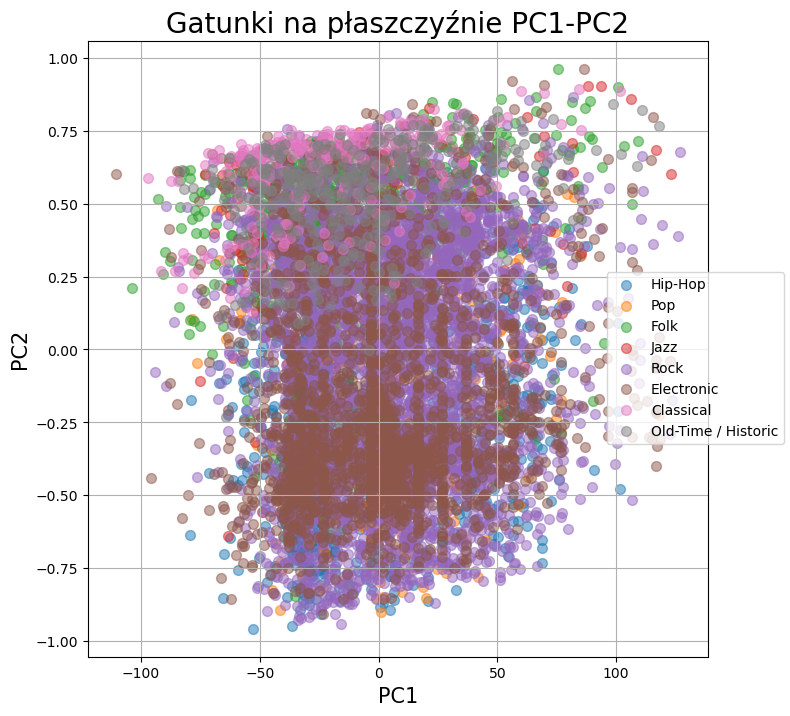

In [252]:
scatter_plot(dataframe=all_data_df, labels_column='genre_top')

Co prawda składowe PC1 i PC2 wyjaśniają prawie całą wariancję, ale to nie jest wystarczające do tego, by odróżnić od siebie poszczególne gatunki. Na wykresie nakładają się one na siebie i nie są widoczne wyraźne skupienia oddzielone od siebie.

# Algorytm k-średnich

Spróbujemy utworzyć nowe gatunki muzyczne, które byłyby możliwe do odróżnienia od siebie na podstawie składowych głównych. W tym celu wykorzystamy algorytm k-średnich [(`from sklearn.cluster import KMeans`)](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Działa on następująco:

1. Wybieramy liczbę *k* klas, na które chcielibyśmy podzielić dane.
2. Wyznaczane są środki (tzw. centroidy) tych *k* klas, np. w sposób losowy, i obliczana odległość każdego obiektu od nich. Obiekt zostaje przyporządkowany tej klasie, której centroida znajduje się najbliżej.
3. Ustalane są nowe środki skupień, np. wyznaczane jako średnia wszystkich obiektów ze skupienia, ponownie obliczane są odległości obiektów od nowych środków i tworzony jest nowy podział.

Kroki 2 i 3 są powtarzane do czasu, aż zostanie osiągnięty warunek zatrzymania (zazwyczaj jest to określona na początku liczba iteracji lub dojście do momentu, gdy podział przestaje się zmieniać pomimo kolejnych iteracji).

Musimy zdefiniować, ile skupień chcemy uzyskać (`n_clusters`). Na początek dajmy 8, czyli tyle, ile gatunków muzycznych mamy w wyczyszczonym zbiorze danych.
Ponieważ nasze dane są dość gęste, możemy podać też argument `n_init` - jest to liczba losowych podziałów na skupienia przy inicjalizacji algorytmu. Ostateczny podział jest wybierany spośród nich tak, by odległości centroidów od wszystkich obiektów w skupieniu były możliwie najmniejsze (tj. by grupy były jak najbardziej zwarte).

In [253]:
kmeans = KMeans(n_clusters=8, random_state=0, n_init=10) #n_init - liczba losowych podziałów na skupienia, które zostaną wykonane. Ostateczny podział jest wybierany spośród n wykonanych podziałów tak, by odległości centroidów od wszystkich obiektów w skupieniu były możliwie najmniejsze

#znajdujemy skupienia w danych oraz przypisujemy obserwacjom nowe etykiety (nowe gatunki) - one już nie mają interpretacji słownej
all_data_df.loc[:,'genre_kmeans'] = kmeans.fit_predict(all_data_df[['PC1','PC2']]) 

/var/folders/bk/2_0z1p453hx_s4fbqb5k60mm0000gn/T/ipykernel_51463/3420577907.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_df.loc[:,'genre_kmeans'] = kmeans.fit_predict(all_data_df[['PC1','PC2']])


Powtórzmy wizualizację, tym razem używając etykiet przypisanych przez algorytm k-średnich. Skorzystamy z zapisanej funkcji:

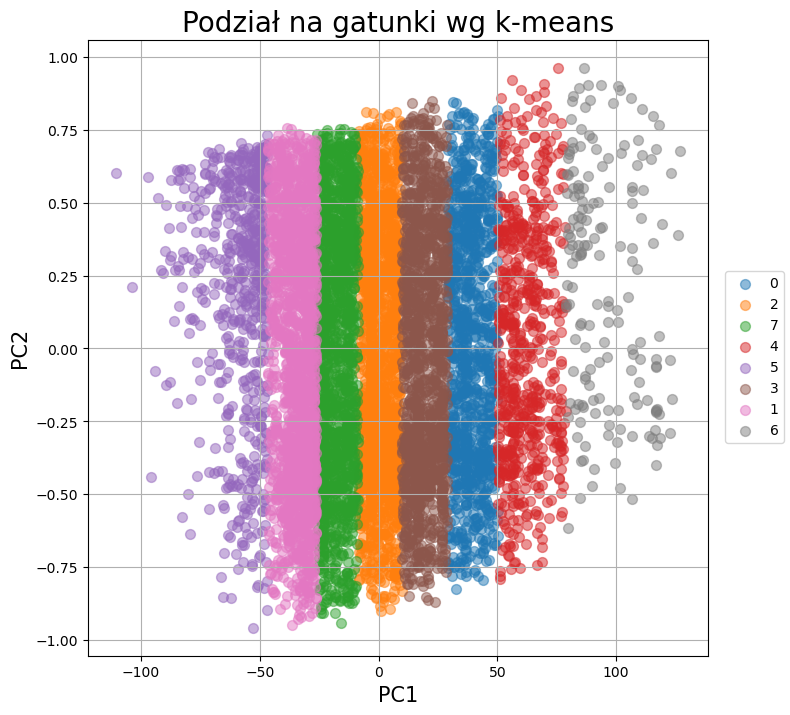

In [254]:
scatter_plot(dataframe=all_data_df, labels_column='genre_kmeans', custom_title='Podział na gatunki wg k-means')

Jak widać, powyższe wyniki nie mają większego sensu - skupienia są utworzone, ale stykają się ze sobą i bez zastosowania różnych kolorów nie dałoby się ich zauważyć na wykresie. Właściwie cały podział dokonany jest na podstawie składowej 1.

O czymś jednak zapomnieliśmy - przed wykonaniem PCA trzeba ustandaryzować dane. Tutaj tego nie zrobiliśmy, co może mieć istotny wpływ na uzyskane rezultaty. 

# Udział cech w składowej PCA

Zobaczmy najpierw, w jaki sposób każda składowa jest wyznaczana z cech podawanych do PCA - macierz `pca.components_` ma wymiary `n_składowych` $\times$ `n_zmiennych` i opisuje udział poszczególnych zmiennych w każdej składowej. Łatwiej będzie ocenić to na wykresie - zwizualizujmy pierwszą składową: 

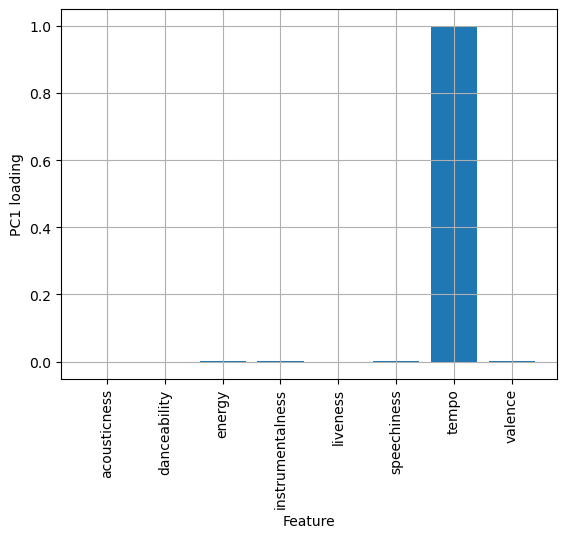

In [255]:
plt.bar(feats_names, pca.components_[0,:])
plt.xlabel('Feature')
plt.xticks(rotation=90)
plt.ylabel('PC1 loading')
# plt.yscale('log')
plt.grid()
plt.show()

Jak widać, składowa PC1 jest praktycznie równoznaczna z tempem utworu - jeśli wyświetlimy zakres wartości dla każdego parametru, zobaczymy, że wszystkie oprócz tempa są wartościami z zakresu $[0, 1]$:

In [256]:
all_data_df[feats_names].describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
count,9.055000e+03,9055.000000,9055.000000,9055.000000,9055.000000,9055.000000,9055.000000,9055.000000
mean,5.261078e-01,0.468705,0.543497,0.655938,0.189837,0.100598,123.282474,0.430489
std,3.862569e-01,0.191946,0.283540,0.356474,0.158591,0.136736,35.247287,0.274529
min,9.035000e-07,0.051307,0.000020,0.000000,0.025297,0.023234,12.753000,0.000010
25%,9.753813e-02,0.322608,0.322091,0.393461,0.102250,0.037351,95.738500,0.190450
50%,5.760434e-01,0.457458,0.558235,0.847694,0.120050,0.049827,120.300000,0.405553
75%,9.240577e-01,0.610483,0.790281,0.922872,0.218404,0.087460,146.600000,0.653458
max,9.957965e-01,0.966883,0.999964,0.998016,0.971968,0.966177,250.059000,0.999990


# Standaryzacja
## PCA

Wykonajmy standaryzację danych przed użyciem algorytmu PCA i powtórzmy dalsze kroki aż do wyświetlenia skupień uzyskanych poprzez użycie algorytmu k-średnich.

In [257]:
scaled_feats = StandardScaler().fit_transform(all_data_df[feats_names])
# zapiszmy przeskalowane dane do nowej tabeli:
scaled_data_df = pd.DataFrame(scaled_feats, columns=feats_names)
# ponieważ tylko przeskalowaliśmy dane, nie zmieniając struktury tabeli, możemy przepisać ID utworów i etykiety gatunków z poprzedniej tabeli:
scaled_data_df[['track_id', 'genre_top', 'genre_numeric_label']] = all_data_df[['track_id', 'genre_top', 'genre_numeric_label']]

pca = PCA(n_components=8)
PCA_feats = pca.fit_transform(scaled_data_df[feats_names])
scaled_data_df['PC1'] = PCA_feats[:,0]
scaled_data_df['PC2'] = PCA_feats[:,1]

Sprawdźmy, jak teraz przedstawia się stopień wyjaśnienia wariancji przez składowe i udział poszczególnych cech:

Stopień wyjaśnienia wariancji:
[0.2303 0.1784 0.1467 0.1222 0.111  0.0934 0.071  0.0472]


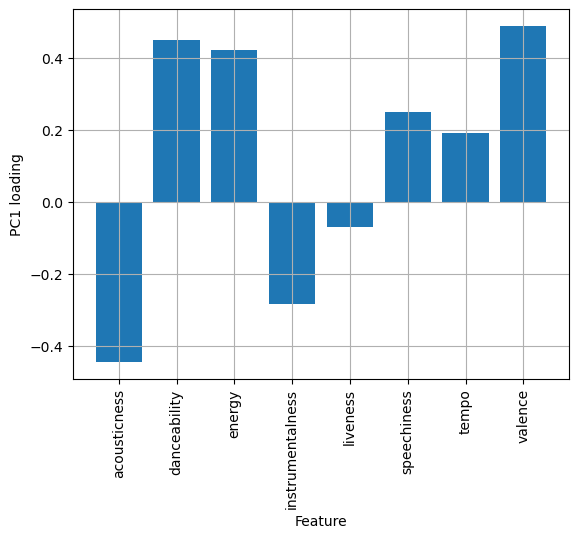

In [258]:
print('Stopień wyjaśnienia wariancji:')
with np.printoptions(precision=4, suppress=True):
    print(pca.explained_variance_ratio_)

plt.bar(feats_names, pca.components_[0,:])
plt.xlabel('Feature')
plt.xticks(rotation=90)
plt.ylabel('PC1 loading')
plt.grid()

Procent wyjaśniania zmienności przez kolejne składowe znacznie się zmienił po standaryzacji, podobnie jak udział poszczególnych cech w pierwszej składowej. Zobaczmy, jak to wygląda na wykresie:

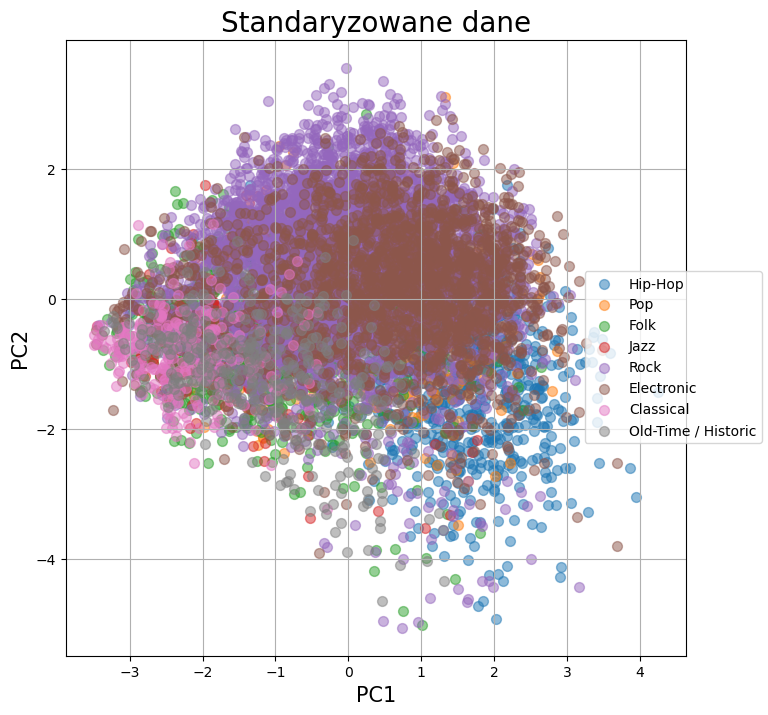

In [259]:
scatter_plot(dataframe=scaled_data_df, labels_column='genre_top', custom_title='Standaryzowane dane')

Reprezentacja jest inna, ale gatunki nadal są mocno wymieszane. Przeprowadźmy teraz analizę skupień na ustandaryzowanych danych.

## k-średnich po standaryzacji

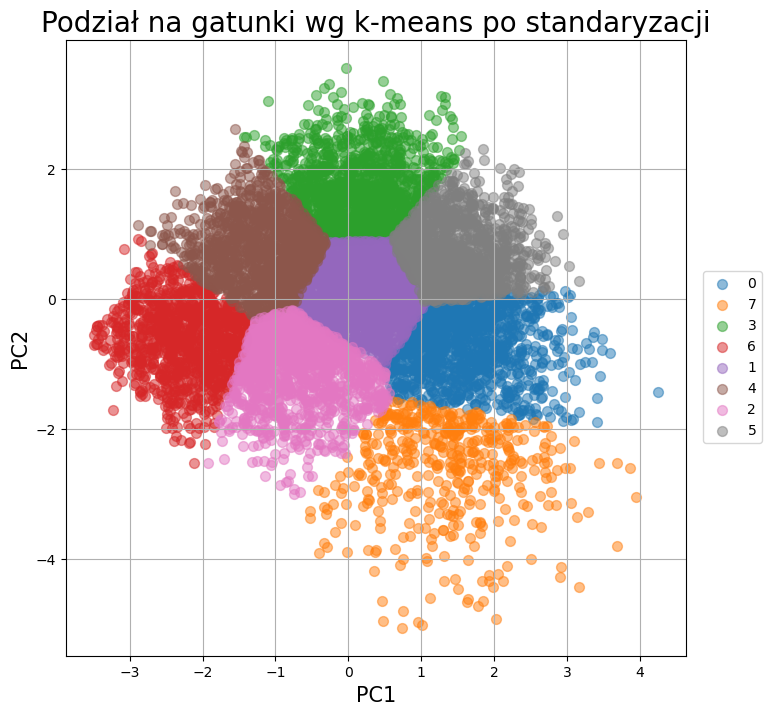

In [260]:
kmeans = KMeans(n_clusters=8, random_state=0, n_init=10) #n_init - liczba losowych podziałów na skupienia, które zostaną wykonane. Ostateczny podział jest wybierany spośród n wykonanych podziałów tak, by odległości centroidów od wszystkich obiektów w skupieniu były możliwie najmniejsze

scaled_data_df['genre_kmeans'] = kmeans.fit_predict(scaled_data_df[['PC1','PC2']]) 

scatter_plot(dataframe=scaled_data_df, labels_column='genre_kmeans', custom_title='Podział na gatunki wg k-means po standaryzacji')

Wyniki są inne, podział nadal sprawia jednak wrażenie arbitralnego - podana liczba skupień nie odzwierciedla rzeczywistego zróżnicowania danych. Spróbujemy coś z tym zrobić.


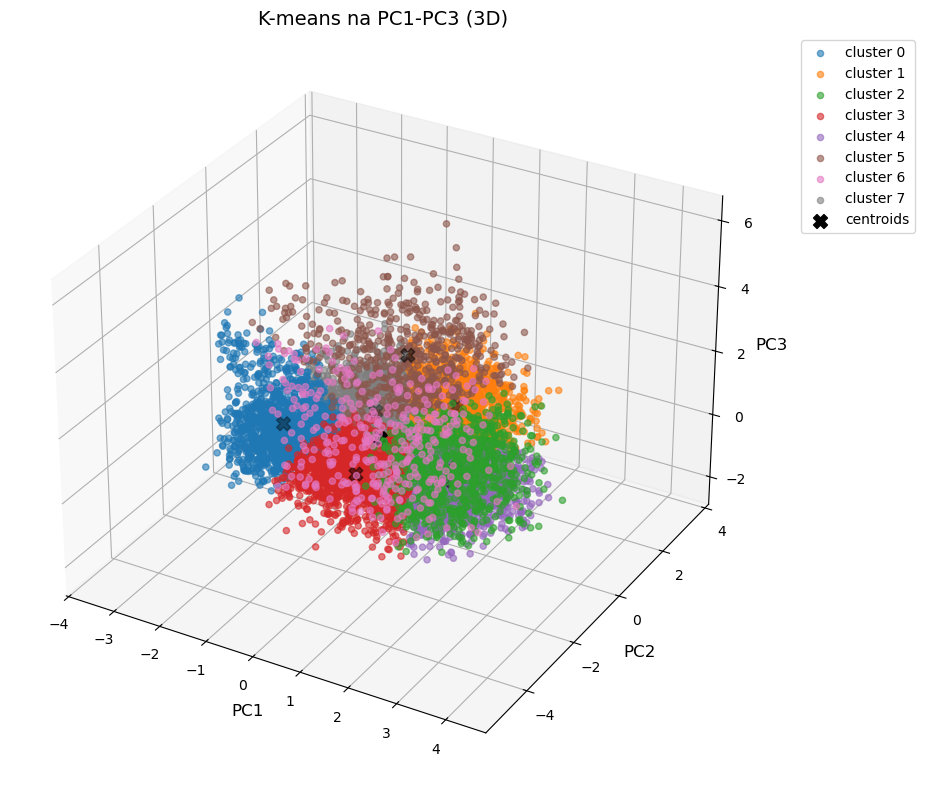

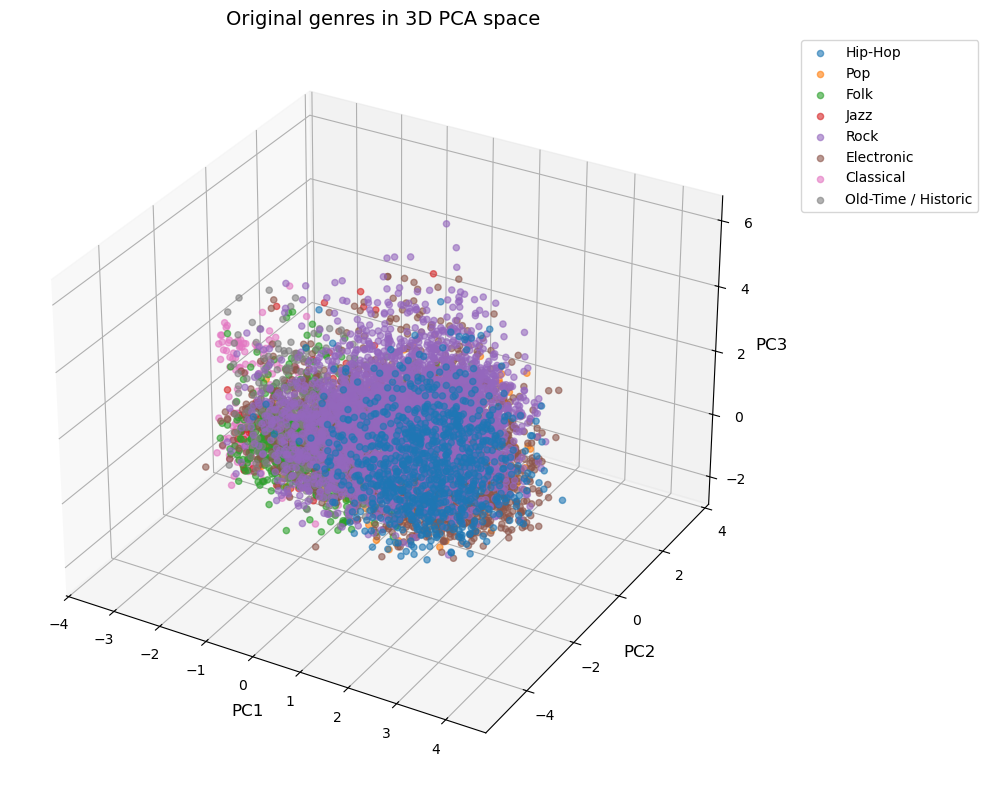

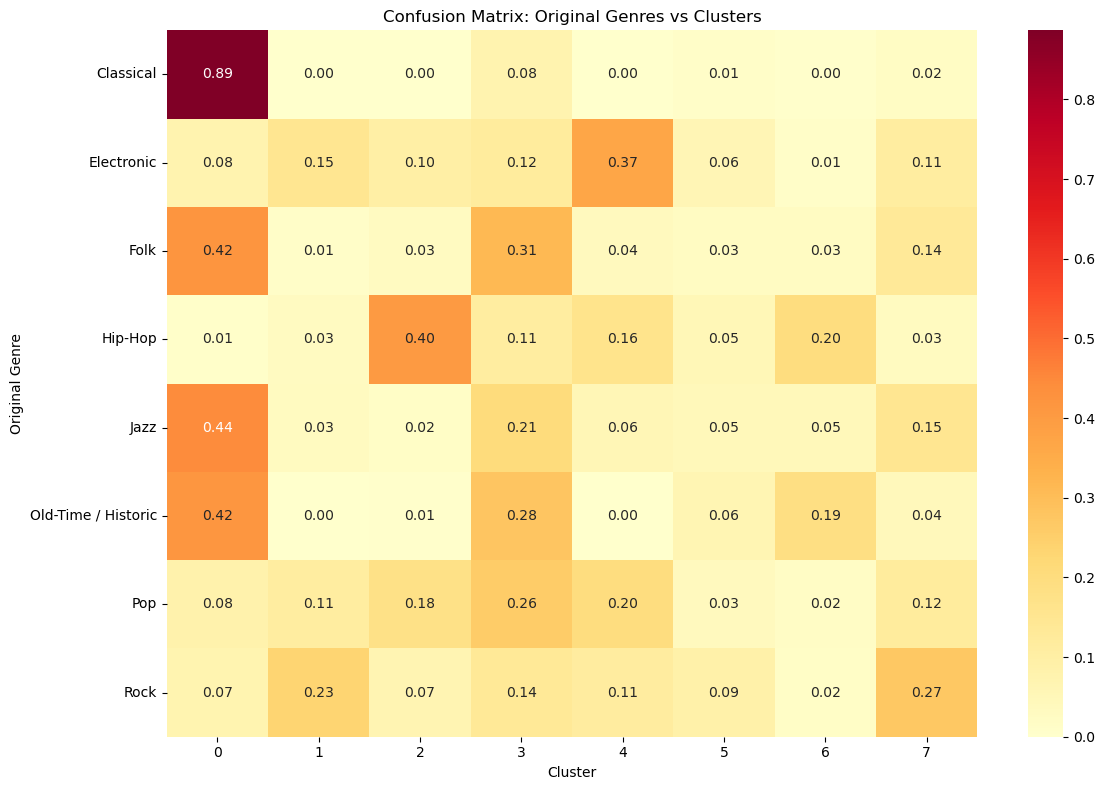

In [261]:
# PC3 z PCA_feats
scaled_data_df['PC3'] = PCA_feats[:, 2]

kmeans3 = KMeans(n_clusters=8, random_state=0, n_init=10)
scaled_data_df['genre_kmeans_3d'] = kmeans3.fit_predict(scaled_data_df[['PC1', 'PC2', 'PC3']])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
ax.set_zlabel('PC3', fontsize=12)
ax.set_title('K-means na PC1-PC3 (3D)', fontsize=14)

cmap = plt.get_cmap('tab10')
clusters = sorted(scaled_data_df['genre_kmeans_3d'].unique())

for cl in clusters:
    mask = scaled_data_df['genre_kmeans_3d'] == cl
    ax.scatter(scaled_data_df.loc[mask, 'PC1'],
               scaled_data_df.loc[mask, 'PC2'],
               scaled_data_df.loc[mask, 'PC3'],
               label=f'cluster {cl}',
               s=20,
               alpha=0.6,
               color=cmap(cl % cmap.N))

centers = kmeans3.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2],
           c='black', s=100, marker='X', label='centroids')

ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
ax.set_zlabel('PC3', fontsize=12)
ax.set_title('Original genres in 3D PCA space', fontsize=14)

for genre in scaled_data_df['genre_top'].unique():
    mask = scaled_data_df['genre_top'] == genre
    ax.scatter(scaled_data_df.loc[mask, 'PC1'],
               scaled_data_df.loc[mask, 'PC2'],
               scaled_data_df.loc[mask, 'PC3'],
               label=genre,
               s=20,
               alpha=0.6)

ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

confusion = pd.crosstab(scaled_data_df['genre_top'], 
                       scaled_data_df['genre_kmeans_3d'], 
                       normalize='index')

plt.figure(figsize=(12, 8))
sns.heatmap(confusion, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Confusion Matrix: Original Genres vs Clusters')
plt.xlabel('Cluster')
plt.ylabel('Original Genre')
plt.tight_layout()
plt.show()


# Zadanie A

Spróbuj uzyskać lepszą klasteryzację:
1. Zmniejszając liczbę klas, na które dane mają być podzielone przez algorytm k-średnich.
2. Zmniejszając liczbę cech, które podawane są do PCA - wybierz takie, które według Ciebie najlepiej będą nadawały się do odróżniania od siebie gatunków muzycznych (istniejących lub nowych).
3. Zmniejszając zarówno liczbę cech, jak i liczbę klas.

In [262]:
feats_names.remove('tempo')

In [263]:
scaled_feats = StandardScaler().fit_transform(all_data_df[feats_names])
scaled_data_df = pd.DataFrame(scaled_feats, columns=feats_names)
scaled_data_df[['track_id', 'genre_top', 'genre_numeric_label']] = all_data_df[['track_id', 'genre_top', 'genre_numeric_label']]

pca = PCA(n_components=7)
PCA_feats = pca.fit_transform(scaled_data_df[feats_names])
scaled_data_df['PC1'] = PCA_feats[:,0]
scaled_data_df['PC2'] = PCA_feats[:,1]

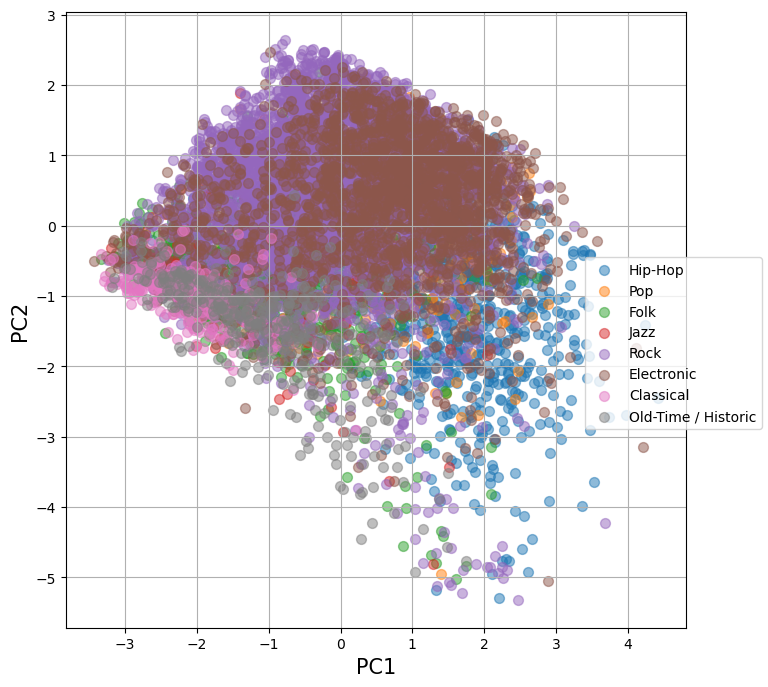

In [264]:
scatter_plot(dataframe=scaled_data_df, labels_column='genre_top', custom_title='')


# Zadanie B

Teraz nowe gatunki tworzyliśmy na podstawie składowych głównych. Można też użyć algorytmu k-średnich na cechach oryginalnych (cech stanowiących podstawę klasyfikacji może być więcej niż 2), a skupienia uzyskane w ten sposób zwizualizować na płaszczyźnie PC1-PC2. Zrób to i zobacz, czy podziały uzyskane na podstawie cech oryginalnych oraz składowych głównych będą się mocno różnić. Sprawdź, czy w przypadku cech oryginalnych lepiej sprawdzą się dane przed, czy po standaryzacji.

/var/folders/bk/2_0z1p453hx_s4fbqb5k60mm0000gn/T/ipykernel_51463/2337942297.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_df['kmeans_orig_labels'] = clusters_B


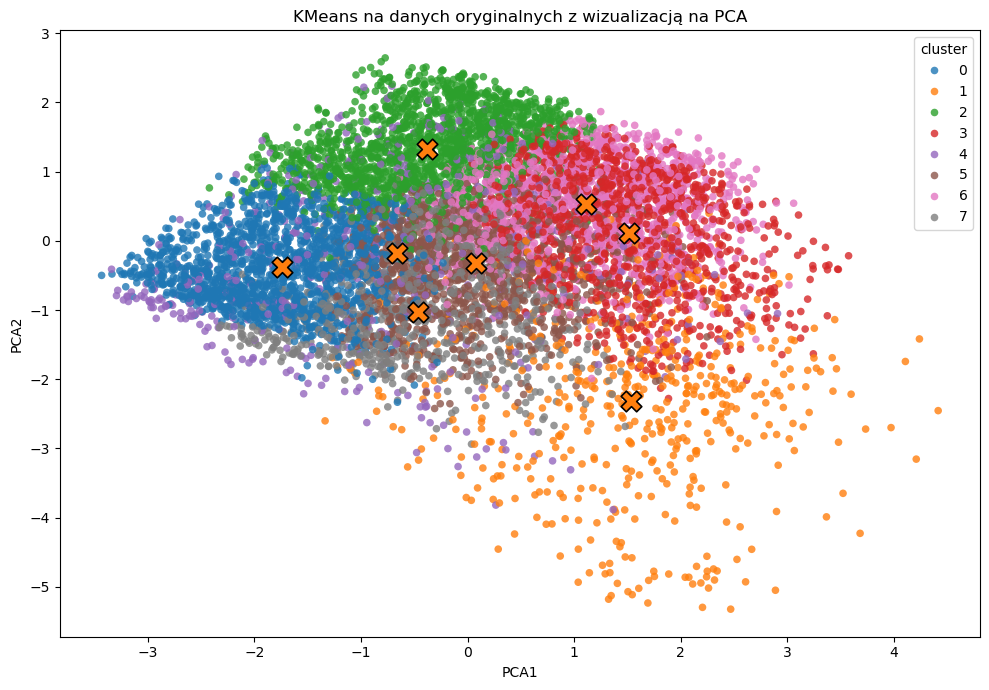

In [265]:
scaler_B = StandardScaler()
X_B = scaler_B.fit_transform(all_data_df[feats_names])

k_B = 8 # liczba klastrów
kmeans_B = KMeans(n_clusters=k_B, random_state=0, n_init=10)
clusters_B = kmeans_B.fit_predict(X_B)
all_data_df['kmeans_orig_labels'] = clusters_B

pca_vis = PCA(n_components=2, random_state=0)
X_B_pca2 = pca_vis.fit_transform(X_B)

centroids_B = kmeans_B.cluster_centers_
centroids_B_pca2 = pca_vis.transform(centroids_B)

pca_plot_df = pd.DataFrame({
    'PCA1': X_B_pca2[:, 0],
    'PCA2': X_B_pca2[:, 1],
    'cluster': clusters_B.astype(int)
})

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_plot_df,
    x='PCA1', y='PCA2',
    hue='cluster',
    palette='tab10',

    s=30, alpha=0.8, linewidth=0
)

plt.scatter(
    centroids_B_pca2[:, 0],
    centroids_B_pca2[:, 1],
    marker='X', s=220, edgecolor='black', linewidth=1.2, zorder=5, label='Centroidy'
)

plt.title('KMeans na danych oryginalnych z wizualizacją na PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.tight_layout()
plt.show()


# Zadanie C

Który podział uważasz za lepszy, ten na podstawie cech oryginalnych czy składowych głównych? Który jest wg Ciebie bardziej sensowny pod względem interpretacji tego, na podstawie czego przyporządkowujemy utwory do nowych gatunków? Napisz swój komentarz na upelu.